## Label processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
ships = pd.read_csv('../data/train_ship_segmentations_v2.csv/train_ship_segmentations_v2.csv')

In [3]:
ships.head(10)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...

In [4]:
ships.shape

(231723, 2)

As we can see, csv file contains `ImageId` and `EncodedPixels`. `ImageId` are not unique, so each row in dataframe is a bounding box of separate ship.

In [5]:
print(type(ships['EncodedPixels'][0]))
print(type(ships['EncodedPixels'][2]))

<class 'float'>
<class 'str'>


`EncodedPixels` column has two data types, so we can replace None with an empty text 

In [6]:
ships['EncodedPixels'].replace(to_replace=np.nan, value="none", inplace=True)

To get more usability we can merge segments of the same image together

In [7]:
unique_ships = ships.groupby('ImageId', as_index=False)['EncodedPixels'].apply(' '.join)
unique_ships.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                               none
1  0001124c7.jpg                                               none
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  0001b1832.jpg                                               none

In [8]:
unique_ships.shape

(192556, 2)

We got total 192556 images, 150000 of them are not contain any ship. Smaller datatframe match with the size of dataset of images

In [34]:
# just to be sure that no images contain Nan and not Nan EncodedPixels
pd.Series(filter(lambda x: "none" in x and len(x) > 4, unique_ships['EncodedPixels']))

Series([], dtype: object)

In [10]:
# store only non-empty masks
unique_ships_selected = unique_ships[unique_ships['EncodedPixels']!="none"]

In [11]:
unique_ships_selected.to_csv('../data/train_ship_segmentations_v2.csv/train_filtered_ships.csv')

In [35]:
# Save groupped dataset to use it later
unique_ships.to_csv('../data/train_ship_segmentations_v2.csv/train_grouped_ship_segmentations_v2.csv')

For U-net architecture we need to get a 2d mask with corresponding class labels. For this task, we mark `ship` as `1` and the rest of the image as `0`

In [36]:
# convert EncodedPixels into 2d masks

def mask_converter(values):
    mask = np.zeros((768*768,), dtype=float)        #create empty one-dimentional vector with zeros
    if values != "none":
        values = values.strip().split()
        start_points = values[0::2]               #separate values
        lengths = values[1::2]
        for st_p, l in zip(start_points, lengths):     #fill mask with ones according to the EncodedPixels colomn
            st_p, l = int(st_p)-1, int(l)
            ones = np.ones(l, dtype=int) 
            mask[int(st_p):int(st_p)+int(l)] = ones
    return np.transpose(mask.reshape((768, 768, 1)), axes=(1, 0, 2))    #rotate image to get correct orientation

Now we have masks that can be used to fit model

In [37]:
unique_ships[unique_ships['ImageId'] == "000155de5.jpg"]['EncodedPixels'].values[0]

'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

In [38]:
# plot image-mask pair
def plotImageWithMask(directory, files):
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    # get_pics
    images = []
    i = 0
    for file in files:
        image = load_img(os.path.join(directory, file), grayscale=False, color_mode='rgb', target_size=(768,768))
        image = img_to_array(image)/255
        mask = mask_converter(unique_ships[unique_ships['ImageId'] == file]['EncodedPixels'].values[0])
        ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
        ax.imshow(image, cmap='binary')
        ax = fig.add_subplot(6, 6, i + 2, xticks=[], yticks=[])
        ax.imshow(mask)
        i+=2
    

Plot some image-mask pairs (from left to right) to be sure converter works correctly

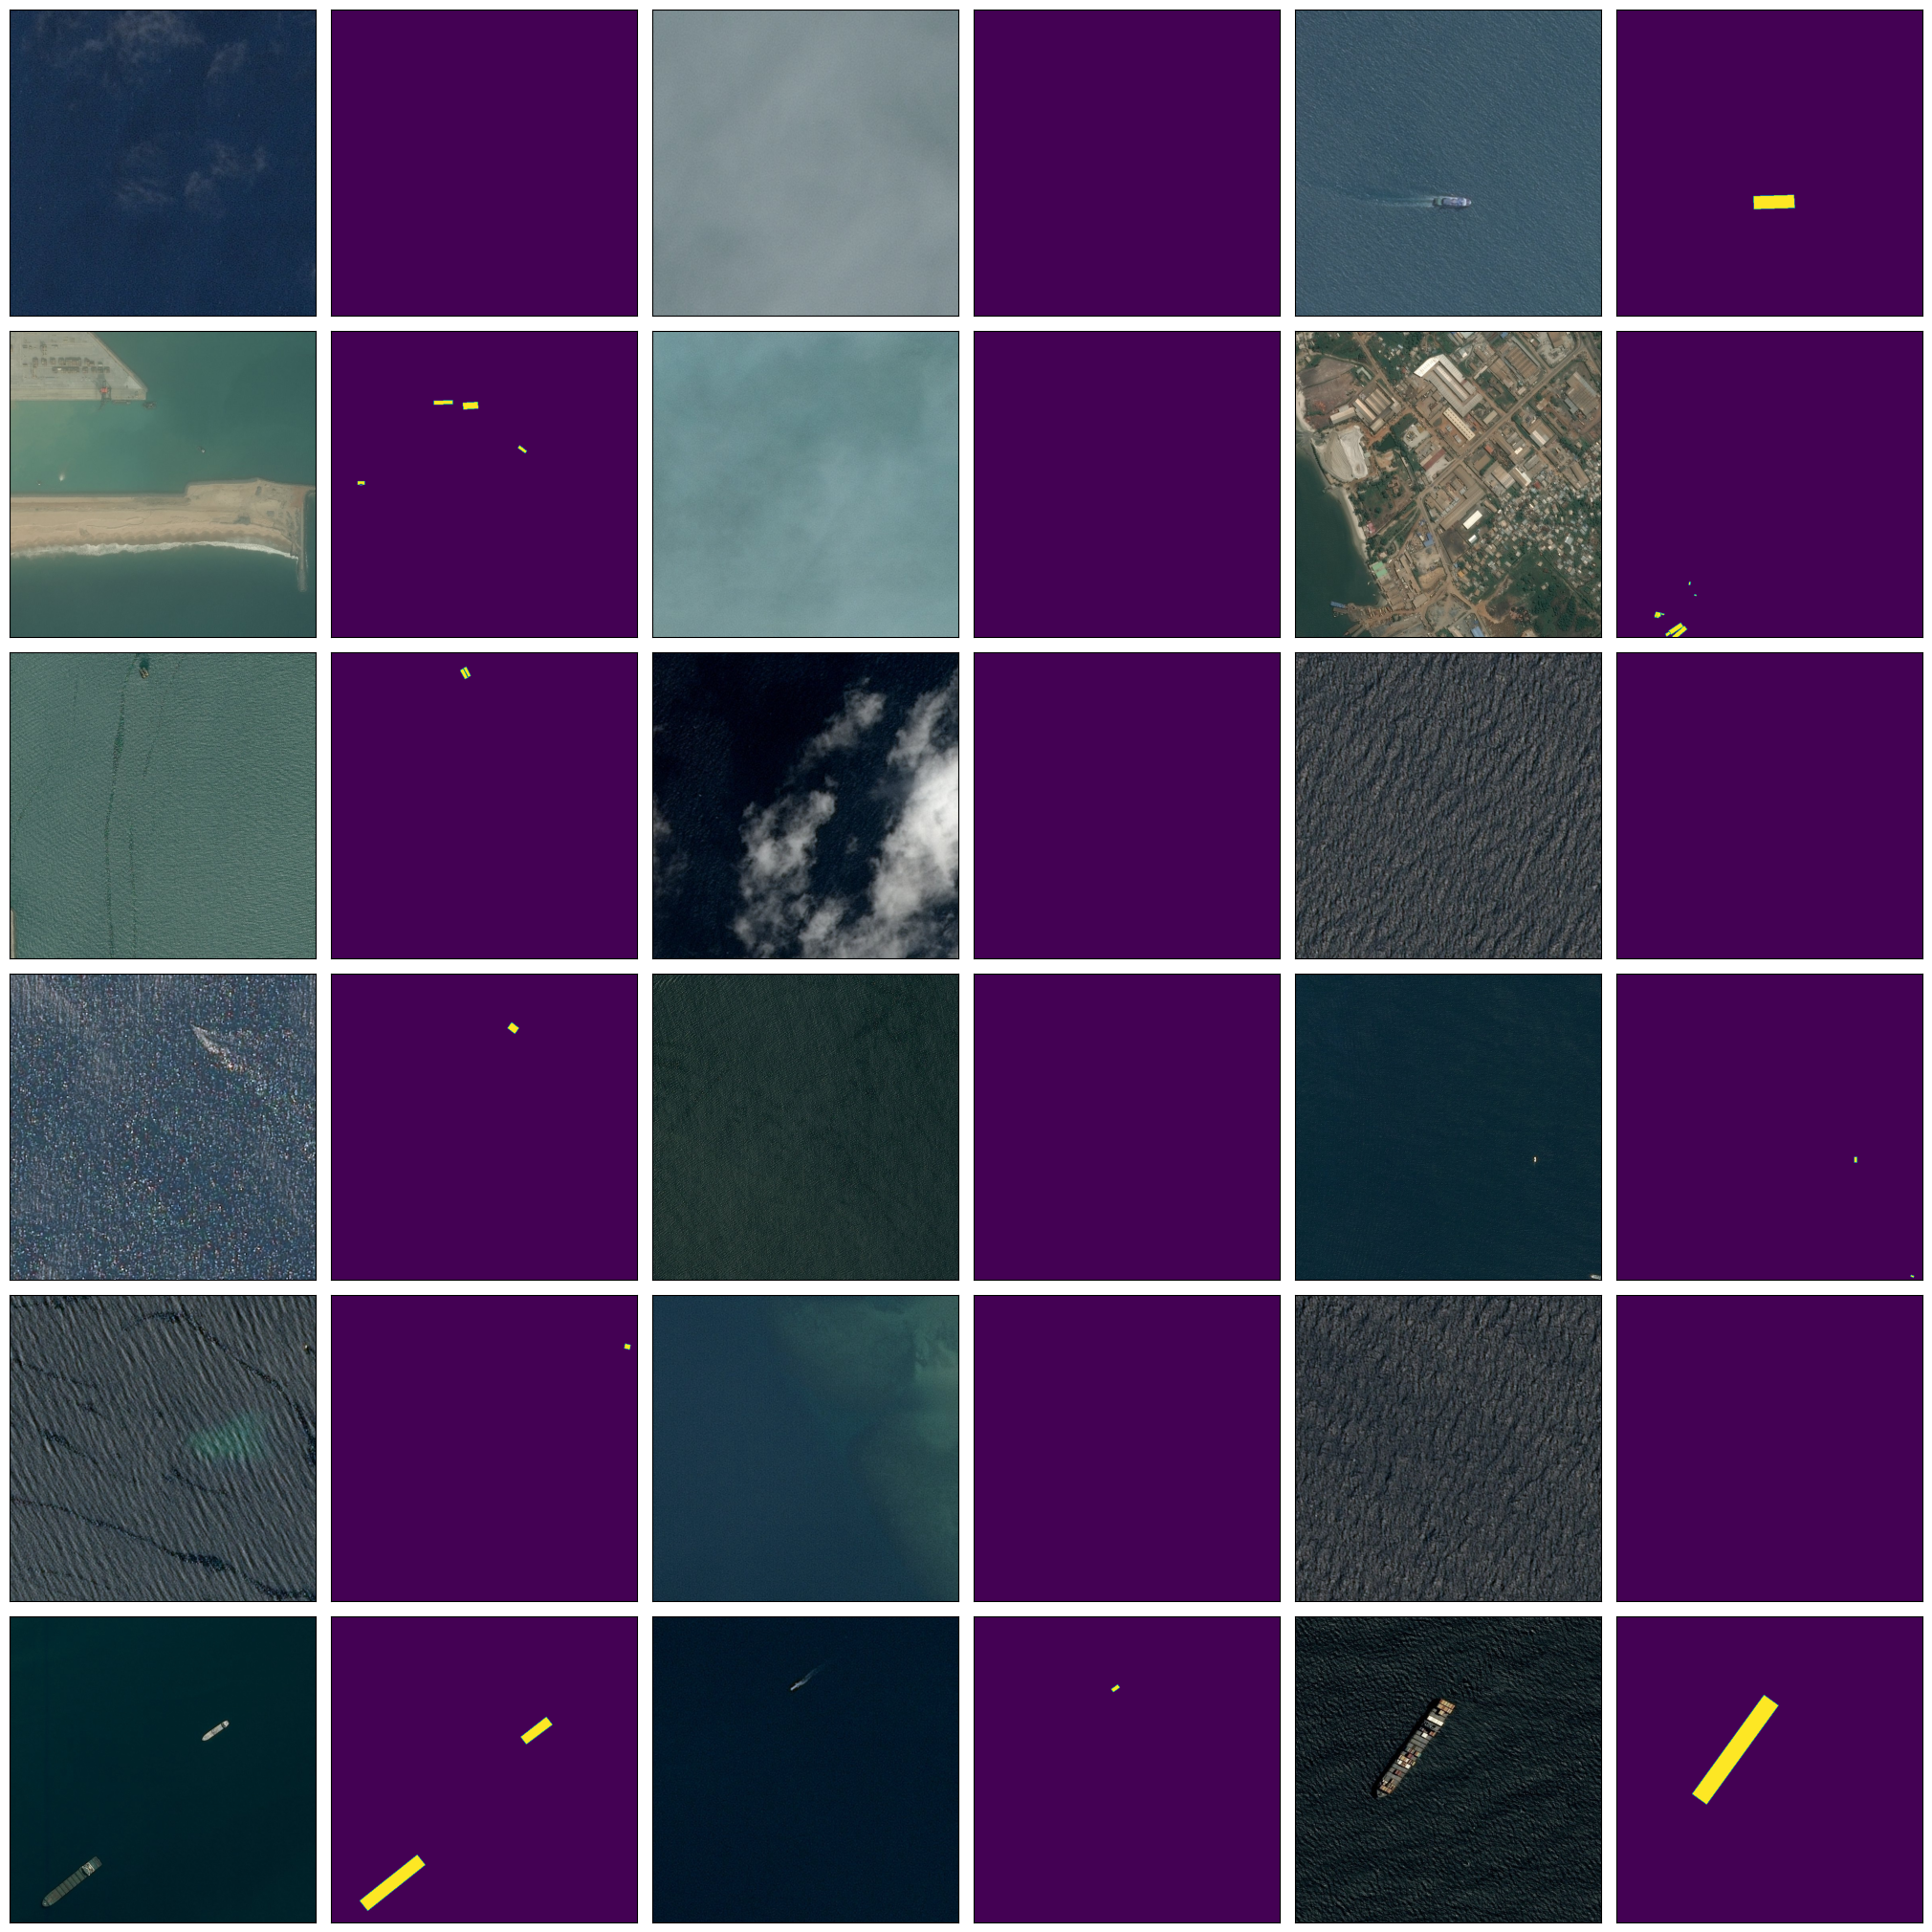

In [39]:
directory = '../data/train_v2'
files=os.listdir(directory)[:18]
plotImageWithMask(directory, files)

At this point that is all we needed to do to preprocess labels